In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
import matplotlib.patches as patches
import scipy.misc
import dicom
import os
import cv2
import glob
%matplotlib inline

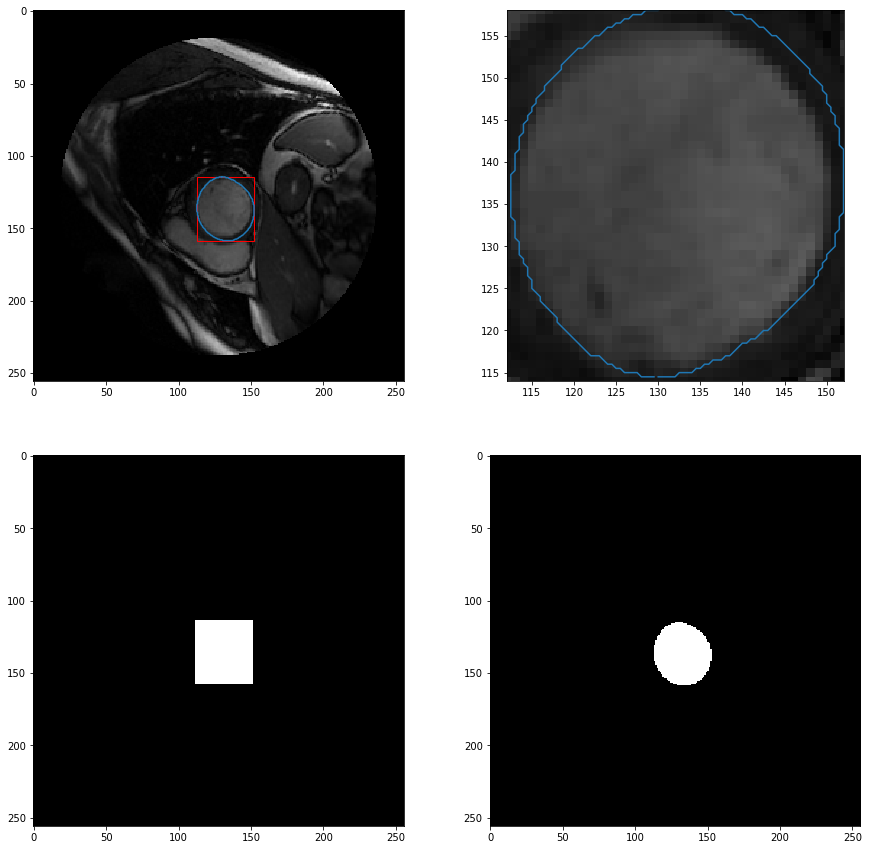

In [6]:
case = 'SC-HF-I-01'
series = {'SC-N-40' : '0944',
          'SC-N-03' : '0915',
          'SC-N-02' : '0898',
          'SC-HYP-40' : '0755',
          'SC-HYP-38' : '0734',
          'SC-HYP-03' : '0650',
          'SC-HYP-01' : '0550',
          'SC-HF-NI-36' : '0474',
          'SC-HF-NI-34' : '0446',
          'SC-HF-NI-04' : '0501',
          'SC-HF-NI-03' : '0379',
          'SC-HF-I-40' : '0134',
          'SC-HF-I-04' : '0116',
          'SC-HF-I-02' : '0106',
          'SC-HF-I-01' : '0004'}
image_path_base = 'Data/challenge_training/%s/IM-%s' % (case, series[case])
contour_path_base = 'Data/Sunnybrook Cardiac MR Database ContoursPart3/\
TrainingDataContours/%s/contours-manual/IRCCI-expert/' % case
contours_list = glob.glob(contour_path_base + '*')

contours_list_series = [k.split('/')[-1].split('-')[3] for k in contours_list]
contour_chosen = np.random.choice(contours_list_series)
idx_contour = contours_list_series.index(contour_chosen)
contour_path = contours_list[idx_contour]
image_path = image_path_base + '-%s.dcm' % contour_chosen

image_part = dicom.read_file(image_path).pixel_array  
contour = []
file = open(contour_path, 'r') 
for line in file: 
    contour.append(tuple(map(float, line.split())))
contour = np.array(contour)

# ROI = rectangle autour du contour
X_min, Y_min = contour[:,0].min(), contour[:,1].min()
X_max, Y_max = contour[:,0].max(), contour[:,1].max()
w = contour[:,0].max() - contour[:,0].min() 
h = contour[:,1].max() - contour[:,1].min()

# Mask
mask_roi = np.zeros(image_part.shape)
mask_roi[int(contour[:,1].min()):int(contour[:,1].max()), 
         int(contour[:,0].min()):int(contour[:,0].max())] = 1.0

x, y = np.meshgrid(np.arange(256), np.arange(256)
x, y = x.flatten(), y.flatten()
points = np.vstack((x,y)).T 
p = Path(contour)
grid = p.contains_points(points)
mask_contour = grid.reshape(256,256)
  
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax[0, 0].imshow(image_part, cmap='gray')
ax[0, 0].plot(*zip(*contour))
rect = patches.Rectangle(
        (X_min,Y_min),
        w, h,
        linewidth=1, edgecolor='r', facecolor='none')
ax[0, 0].add_patch(rect)

ax[1, 0].imshow(mask_roi, cmap='gray')
ax[1, 1].imshow(mask_contour*1, cmap='gray')
ax[0, 1].imshow(image_part, cmap='gray')
ax[0, 1].plot(*zip(*contour))
ax[0, 1].set_xlim(int(contour[:,0].min()), int(contour[:,0].max()))
t = ax[0, 1].set_ylim(int(contour[:,1].min()), int(contour[:,1].max()))

#Save images and segmentations
label = 1 - mask_contour*1
x,y = label.shape
str_label = ''
delimiter='\t '

for i in range(0,x):
    for j in range(0,y):
        str_label += str(int(label[i][j])) + delimiter
    str_label = str_label[:-len(delimiter)] + '\n'

name_file = 'Images_ventricules/gound_truth_%s_IM%s.txt' % (case, series[case])
segmentation = open(name_file,'w')
segmentation.write(str_label)
segmentation.close()
name_image = 'Images_ventricules/%s_IM%s.jpg' % (case, series[case])
scipy.misc.imsave(name_image, image_part)